# 01: Google Earth Engine
Date: 2022-08-26

Play around with Google Earth Engine and see what we can do!

In [67]:
import ee
import geemap
import folium
import time

In [12]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [13]:
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


In [14]:
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')
print(img)

ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.load",
    "arguments": {
      "id": {
        "constantValue": "LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913"
      }
    }
  }
})


This resource was very helpful in getting started: [https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api).

In [15]:
lat, lon = 45.77, 4.855

my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map

In [16]:
dmsp92id = "NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F101992"
dmsp92 = ee.Image(dmsp92id)

In [20]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [21]:
# Create a map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=7)

image_viz_params = {
    'bands': ['avg_vis'],
    'min': 0,
    'max': 63
}
# Add the land cover to the map object.
my_map.add_ee_layer(dmsp92id, image_viz_params, 'NightLights')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

This is cool! I can see the nighttime lights now! Things I should figure out:
- What this looks like as data
- Data frequency

## What does this look like as data?

In [22]:
night_collection = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS")

In [94]:
i_date = '2013-01-01'
f_date = '2013-12-31'

night_collection_2010 = night_collection.select('avg_vis').filterDate(i_date, f_date)

In [53]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [95]:
ts = night_collection_2010.getRegion(u_poi, 1000).getInfo()

In [96]:
ts

[['id', 'longitude', 'latitude', 'time', 'avg_vis'],
 ['F182013', 4.810478346460038, 45.77365530231022, 1356998400000, 63]]

Notes from the documentation of this dataset: [https://developers.google.com/earth-engine/datasets/catalog/NOAA_DMSP-OLS_NIGHTTIME_LIGHTS#description](https://developers.google.com/earth-engine/datasets/catalog/NOAA_DMSP-OLS_NIGHTTIME_LIGHTS#description)

Version 4 of the DMSP-OLS Nighttime Lights Time Series consists of cloud-free composites made using all the available archived DMSP-OLS smooth resolution data for calendar years. In cases where two satellites were collecting data, two composites were produced.

So maybe that is why there are more than one for some years. But in general, it seems there is just one image per year.

### We can look at point data like the above for a specific location and we can save a GeoTIFF it looks like

#### Saving a GeoTIFF

In [33]:
task = ee.batch.Export.image.toDrive(image=dmsp92,
                                     description='test_dmsp',
                                     fileNamePrefix='my_export'
)

In [34]:
task.start()

In [36]:
task.status()

{'state': 'FAILED',
 'description': 'test_dmsp',
 'creation_timestamp_ms': 1661554587704,
 'update_timestamp_ms': 1661554595903,
 'start_timestamp_ms': 1661554591801,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'error_message': 'Export too large: specified 725820001 pixels (max: 100000000). Specify higher maxPixels value if you intend to export a large area.',
 'id': 'ZSAWJXJ4GTQLVTS7GLBS55JD',
 'name': 'projects/earthengine-legacy/operations/ZSAWJXJ4GTQLVTS7GLBS55JD'}

Ok, exporting the whole world is apparently way too large, haha. Let's just export Japan maybe!

In [38]:
# Get long and latitude of Japan
u_lat = 35.6762
u_lon = 139.6503
u_poi = ee.Geometry.Point(u_lon, u_lat)

my_map = folium.Map(location=[u_lat, u_lon], zoom_start=7)

image_viz_params = {
    'bands': ['avg_vis'],
    'min': 0,
    'max': 63
}
# Add the land cover to the map object.
my_map.add_ee_layer(dmsp92id, image_viz_params, 'NightLights')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [39]:
# Define a region of interest with a buffer zone of 1500 km around Tokyo.
roi = u_poi.buffer(1.5e6)

In [97]:
night_collection_2010.first()

In [98]:
task = ee.batch.Export.image.toDrive(image=night_collection_2010.first(),
                                     description='test_dmsp',
                                     fileNamePrefix='my_export_2013',
                                     region = roi
)

In [99]:
task.start()

In [102]:
task.status()

{'state': 'RUNNING',
 'description': 'test_dmsp',
 'creation_timestamp_ms': 1661557860767,
 'update_timestamp_ms': 1661557872049,
 'start_timestamp_ms': 1661557869588,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'LT43TQPU5OSJK5WYXCK764FR',
 'name': 'projects/earthengine-legacy/operations/LT43TQPU5OSJK5WYXCK764FR'}

In [103]:
while task.status()['state'] == 'RUNNING':
    time.sleep(10)
    print('Still Running')

Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running
Still Running


Ok that worked!

## See what the TIFF file looks like

In [81]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
im = Image.open('../data/my_export.tif')

In [72]:
im.show()

In [74]:
imarray = np.array(im)

In [78]:
imarray.shape

(3240, 4004)

In [82]:
imarray.max()

63

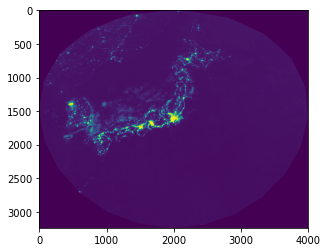

In [80]:
plt.imshow(imarray)

How to make this black and white like it's original? Maybe I can min max scale the numpy array and then multiply by 255?

In [83]:
scaledim = imarray / imarray.max() * 255

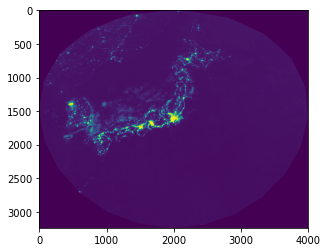

In [84]:
plt.imshow(scaledim)

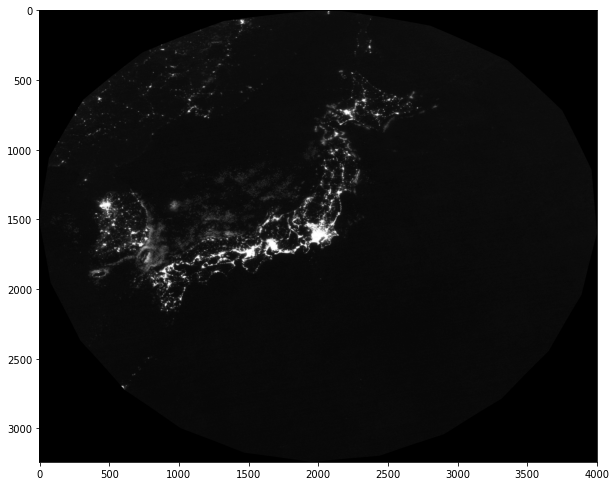

In [93]:
fig = plt.figure(figsize = (10, 10))
fig = plt.imshow(imarray, cmap = 'gray')

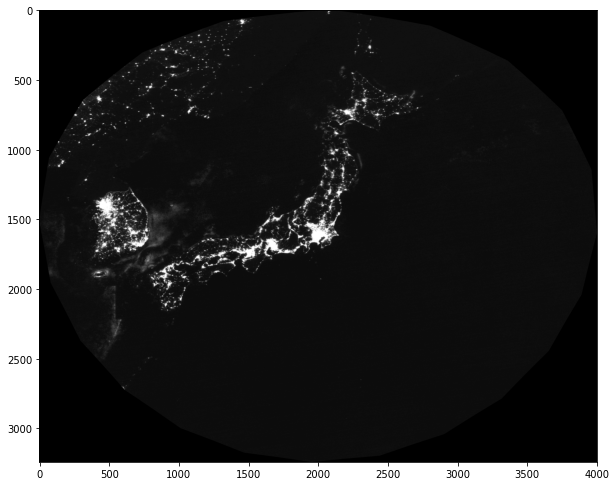

In [104]:
im_2013 = Image.open('../data/my_export_2013.tif')
im_2013_ar = np.array(im_2013)
fig = plt.figure(figsize = (10, 10))
fig = plt.imshow(im_2013_ar, cmap = 'gray')

I wanted to contrast 1992 to 2013 to see if there's any differences. But wow, South Korea is really booming there.
It's interesting that since Japan has been undergoing population decrease, I was hoping to see rural areas get darker but it's hard to say that's the case.

In [105]:
im_2013_ar.shape

(3240, 4004)

In [126]:
# compare the differences
difference = np.subtract(im_2013_ar.astype(np.int16), imarray.astype(np.int16))

In [127]:
difference.min()

-46

In [128]:
difference.max()

59

In [130]:
# points where the lightness decreased
len(np.where(difference < 0)[0])

627471

In [131]:
3240 * 4004

12972960

In [132]:
627471 / (3240 * 4004)

0.048367604617604615

Only 4% of the locations decreased in lightness. For data 2014 and onward I will need to use VIIRS-DNB nighttime lights composite products, which are also available at a monthly frequency.